# IMT 573 - Problem Set 4 - Working With Data Part 2

## Data Wrangling and API Integration

In this lab, I will focus on advanced data wrangling techniques and integration of external data sources through APIs. The primary objectives include:

1. **Data Cleaning and Preprocessing**: Address missing values and ensure data consistency.
2. **API Integration**: Use external APIs to retrieve supplementary information, such as census tract data, and merge it with the existing dataset.
3. **Data Analysis**: Analyze the integrated dataset to derive meaningful insights related to geographic locations and other variables.

This lab emphasizes the importance of working with real-world data sources and the technical skills required to integrate and analyze multiple datasets effectively.

In [3]:
import pandas as pd
import censusgeocode as cg
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
crime_data = pd.read_csv('crime_data.csv')

#### Basic inspection

Perform a basic inspection of the Crime Dataset and discuss is found.

In [6]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523591 entries, 0 to 523590
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Report Number                523591 non-null  int64  
 1   Occurred Date                523589 non-null  object 
 2   Occurred Time                523589 non-null  float64
 3   Reported Date                523591 non-null  object 
 4   Reported Time                523589 non-null  float64
 5   Crime Subcategory            523329 non-null  object 
 6   Primary Offense Description  523591 non-null  object 
 7   Precinct                     523585 non-null  object 
 8   Sector                       520245 non-null  object 
 9   Beat                         520293 non-null  object 
 10  Neighborhood                 523591 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 43.9+ MB


In [7]:
crime_data.head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,1975000079415,12/16/1975,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK
1,1976000069169,01/01/1976,1.0,01/31/1976,2359.0,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN
2,1979000049118,01/28/1979,1600.0,02/09/1979,1430.0,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
3,19810000305573,08/22/1981,2029.0,08/22/1981,2030.0,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,BRIGHTON/DUNLAP
4,1981000076456,02/14/1981,2000.0,02/15/1981,435.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,ROXHILL/WESTWOOD/ARBOR HEIGHTS


In [8]:
missing_data = crime_data.isnull().sum()
print(missing_data)


Report Number                     0
Occurred Date                     2
Occurred Time                     2
Reported Date                     0
Reported Time                     2
Crime Subcategory               262
Primary Offense Description       0
Precinct                          6
Sector                         3346
Beat                           3298
Neighborhood                      0
dtype: int64


In [9]:
'''Sector and Beat have substantial missing data, with 3,346 and 3,298 missing values each, Crime Subcategory has 262 missing values, 
Occurred Date, Occurred Time, and Reported Time have only 2 missing values each '''

'Sector and Beat have substantial missing data, with 3,346 and 3,298 missing values each, Crime Subcategory has 262 missing values, \nOccurred Date, Occurred Time, and Reported Time have only 2 missing values each '

#### (b) Years of crimes

Examine the years in which crimes were committed in the dataset. COnfirm the first year with crime. Find distinct trends with the annual number of crimes committed in the dataset.

In [11]:
# Convert 'Occurred Date' to datetime
crime_data['Occurred Date'] = pd.to_datetime(crime_data['Occurred Date'], errors='coerce')

In [12]:
# Extract the year from 'Occurred Date'
crime_data['Occurred Year'] = crime_data['Occurred Date'].dt.year

In [13]:
# Find the earliest year
earliest_year = crime_data['Occurred Year'].min()
print("Earliest Year:", earliest_year)

Earliest Year: 1908.0


In [14]:
# Analyze the number of crimes per year
crimes_per_year = crime_data['Occurred Year'].value_counts().sort_index()
print("Crimes per Year:")
print(crimes_per_year)

Crimes per Year:
Occurred Year
1908.0        1
1964.0        1
1973.0        1
1974.0        1
1975.0        2
1976.0        2
1977.0        1
1978.0        1
1979.0        2
1980.0        2
1981.0        2
1985.0        2
1986.0        1
1987.0        1
1988.0        1
1989.0        1
1990.0        2
1991.0        4
1993.0        5
1994.0        2
1995.0        6
1996.0        4
1997.0        5
1998.0       20
1999.0        8
2000.0       40
2001.0       53
2002.0       17
2003.0       29
2004.0       43
2005.0       49
2006.0      100
2007.0      627
2008.0    42793
2009.0    45056
2010.0    43353
2011.0    41298
2012.0    41007
2013.0    45551
2014.0    49322
2015.0    47693
2016.0    49220
2017.0    50334
2018.0    51302
2019.0    15624
Name: count, dtype: int64


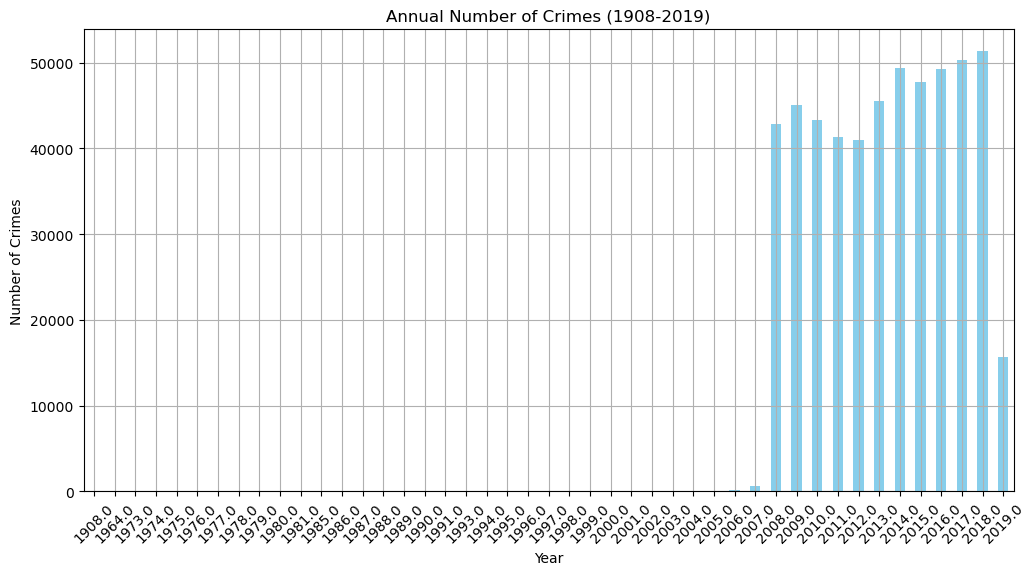

In [15]:
import matplotlib.pyplot as plt

# Plot the number of crimes per year
plt.figure(figsize=(12, 6))
crimes_per_year.plot(kind='bar', color='skyblue')
plt.title('Annual Number of Crimes (1908-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering Data on Years

In this step, I will subset the dataset to only include crimes that were committed after 2011. This ensures we are working with the most relevant and recent data for our analysis. Following good practices of data provenance, I will retain a clean version of the original dataset and print the shape of the new subset to confirm the change.

In [17]:
filtered_crime_data = crime_data[crime_data['Occurred Year'] > 2011]

In [18]:
filtered_crime_data.shape

(350053, 12)

### Analyzing the Frequency of Police Beats

Each crime record is associated with a police beat. In this step, I will examine how frequently each beat appears in the filtered crime dataset. The analysis will help identify any anomalies, such as missing beats or unusual frequencies, that may indicate issues with the data. This check is crucial for ensuring data accuracy before proceeding with further analysis.

In [20]:
# Analyze the frequency of police beats in the filtered dataset
beat_frequency_filtered = filtered_crime_data['Beat'].value_counts(dropna=False)

In [21]:
missing_beats_filtered = filtered_crime_data['Beat'].isnull().sum()
beat_frequency_filtered, missing_beats_filtered

(Beat
 K3     11611
 M2     10210
 E2     10200
 U1     10157
 L2     10049
 M1      9883
 M3      9723
 B2      9253
 Q3      9249
 U3      9019
 U2      8866
 B3      8846
 Q2      8159
 D1      8066
 B1      7954
 N3      7517
 D2      7491
 E1      7459
 R2      7448
 N2      7409
 J3      7203
 E3      7032
 R3      6909
 K1      6611
 J2      6585
 K2      6560
 D3      6530
 W2      6514
 F2      6429
 R1      6080
 S3      6027
 L1      5823
 L3      5710
 C1      5694
 J1      5668
 Q1      5647
 F3      5361
 N1      5303
 W3      5286
 G2      5259
 S2      5139
 W1      5135
 S1      4819
 C2      4789
 C3      4726
 O1      4523
 F1      4332
 G3      4327
 G1      3257
 O3      3239
 O2      2894
 NaN     2054
 DET        7
 S          4
 W          3
 SS         1
 CTY        1
 WS         1
 N          1
 K          1
 Name: count, dtype: int64,
 2054)

In [22]:
''' The most frequent beats include K3, which appears 11,611 times, followed by M2 with 10,210 occurrences, E2 with 10,200, U1 with 10,157,
and L2 with 10,049 appearances. This high frequency suggests these beats cover areas with higher crime rates or more rigorous reporting. , 
several anomalies are present in the dataset. Some beats have very low counts, such as DET appearing only 7 times, S appearing 4 times, 
W appearing 3 times, and beats like SS, CTY, WS, N, and K appearing just once. These low-frequency entries could indicate data recording errors 
Additionally, there are 2,054 records with missing beat information, denoted as NaN '''

' The most frequent beats include K3, which appears 11,611 times, followed by M2 with 10,210 occurrences, E2 with 10,200, U1 with 10,157,\nand L2 with 10,049 appearances. This high frequency suggests these beats cover areas with higher crime rates or more rigorous reporting. , \nseveral anomalies are present in the dataset. Some beats have very low counts, such as DET appearing only 7 times, S appearing 4 times, \nW appearing 3 times, and beats like SS, CTY, WS, N, and K appearing just once. These low-frequency entries could indicate data recording errors \nAdditionally, there are 2,054 records with missing beat information, denoted as NaN '

### Police Beat Data

In this step, I will load the data on Seattle police beats from the **Police_Beat_and_Precinct_Centerpoints.csv** file. This dataset contains geographic information related to police precincts and beats, which will be used in conjunction with the crime data for further analysis. The same data was used previously in Lab 4, and it provides essential context for understanding how crimes are distributed across different precincts and beats.

In [25]:
beats_data = pd.read_csv('Police_Beat_and_Precinct_Centerpoints.csv')

###  Missing Police Beats

In this step, I will check whether the filtered Crime Dataset includes police beats that are not present in the Beats Dataset. Specifically, I will:
- Identify how many missing beats exist and the frequency with which they occur.
- Assess whether these missing beats represent a significant portion of the Crime Dataset or if they are relatively infrequent.
- Evaluate whether removing these missing beats would drastically alter the overall scope and representativeness of the Crime Dataset.

In [27]:
# Extract the list of unique beats from the police beat data
police_beats = beats_data['Name'].unique()

# Identify beats in the filtered crime dataset that are not in the police beat dataset
missing_beats_in_crime_data = filtered_crime_data[~filtered_crime_data['Beat'].isin(police_beats)]

missing_beats_proportion = len(missing_beats_in_crime_data) / len(filtered_crime_data)
print(missing_beats_proportion)

0.005910533547777051


In [28]:
# Using this function shown in class to see if the missing data is statistically significant.
from scipy.stats import ks_2samp
# Separate the dataset into two groups
with_missing_beats = filtered_crime_data[filtered_crime_data['Beat'].isnull() | ~filtered_crime_data['Beat'].isin(police_beats)]
without_missing_beats = filtered_crime_data[filtered_crime_data['Beat'].isin(police_beats)]

In [29]:
# Extract a relevant  column to compare distributions,
with_missing_beats_times = with_missing_beats['Occurred Time'].dropna()
without_missing_beats_times = without_missing_beats['Occurred Time'].dropna()

In [30]:
ks_2samp(with_missing_beats_times, without_missing_beats_times)

KstestResult(statistic=0.07316826964328133, pvalue=5.060954078272701e-10, statistic_location=1.0, statistic_sign=1)

In [31]:
#the very small p-value (5.06 \times 10^{-10}) suggests that the difference between the distributions of the two samples is statistically significant.

### (b) Filtering Police Beats

In this step, I will filter the Crime Dataset to remove:
- Instances where the police beats occur fewer than 10 times in the dataset.
- Any observations with missing beats.

After applying these filters and only keeping the relevant years, I will calculate the number of remaining observations in the Crime Dataset to assess the size and representativeness of the filtered data.

In [34]:
beat_counts = filtered_crime_data['Beat'].value_counts()
frequent_beats = beat_counts[beat_counts >= 10].index

In [35]:
cleaned_crime_data_filtered = filtered_crime_data[filtered_crime_data['Beat'].isin(frequent_beats)].dropna(subset=['Beat'])
cleaned_crime_data_filtered.shape

(347980, 12)

### Adding Census Tract Information to Beats Dataset

To integrate the Beats Dataset with census data, we need to have census tract information for each police beat. In a previous lab, I used an API to retrieve census tract data based on geographic coordinates. I will reuse that code to add a column named **"tract"** to the Beats Dataset.

Following good practices of data provenance, I will ensure that the original data is kept intact while appending this new information for further analysis.

In [37]:
def get_census_tract(lon, lat):
    try:
        result = cg.coordinates(x=lon, y=lat)
        if result and 'Census Tracts' in result and result['Census Tracts']:
            return result['Census Tracts'][0]['GEOID']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving census tract: {e}")
        return None
def extract_11_digit_code(geoid):
   
    if geoid and len(geoid) == 12:
        return geoid[:11]
    return None

### Process for Joining Datasets

Before joining the Beats Dataset with the Crime Dataset, it’s important to consider whether it would have been more efficient to join the datasets first and then retrieve the census tracts. 

**Advantages of Joining First**:
- Reduces the number of API calls if some beats are not present in the Crime Dataset, leading to a more efficient process.
- Ensures that only relevant beats (those present in both datasets) are used for census tract retrieval.

**Disadvantages**:
- If the datasets are large, performing the join first could introduce complexity and slow down the process.
- Finding census tracts beforehand ensures the integrity of the geographic information before merging with crime data, reducing the risk of data inconsistencies post-join.

Understanding the advantages and disadvantages helps determine the most efficient workflow for joining and integrating data.

### Extracting 11-Digit Census Codes

The census data uses an 11-digit code composed of the state, county, and tract codes (without the block code). To join the census data to the Beats Dataset, I will extract the 11-digit code for each beat. This code is made up of:
- 2 digits for the state
- 3 digits for the county
- 6 digits for the tract

I will add a new column named **census_id** to the (modified) Beats Dataset, storing these 11-digit codes as **int64** values to ensure proper format for further analysis and joins.

In [41]:
# Apply the function to get the census tract for each row and add it as a new column 'tract'
beats_data['tract'] = beats_data.apply(lambda row: get_census_tract(row['Longitude'], row['Latitude']), axis=1)

# Extract the 11-digit census code and add it as a new column 'census_id'
beats_data['census_id'] = beats_data['tract'].apply(extract_11_digit_code)

# Convert the 'census_id' column to int64
beats_data['census_id'] = beats_data['census_id'].astype('Int64')

### Extracting 11-Digit Codes from Census Data

I will now examine the **census_data_2020_edu_attainment.csv** file, which contains education attainment counts across different census tracts. The dataset is currently in a "wide" format, but for now, I will work with it as is.

The census data includes a **GEO_ID** column, where the characters after "US" encode the 11-digit census code (state, county, and tract) that aligns with the 11-digit codes extracted for the police beats. I will:
- Extract the 11-digit code from the **GEO_ID** column.
- Add a new column named **census_id** to the Census Dataset with the 11-digit code for each census observation.

As always, I will follow good data provenance practices when modifying the dataset to ensure accuracy and traceability.

In [43]:
# Load the census dataset
census_data = pd.read_csv('census_data_2020_edu_attainment.csv')

In [44]:
def extract_census_id(geo_id):
    if geo_id and geo_id.startswith('US'):
        return geo_id[2:2+11]  # Extract the 11 digits after 'US'
    return None

# Apply the function to extract the 11-digit code and add it as a new column 'census_id'
census_data['census_id'] = census_data['GEO_ID'].apply(extract_census_id)
census_data.head

<bound method NDFrame.head of                    GEO_ID  Population 18 to 24 years  \
0    1400000US53033000101                        278   
1    1400000US53033000102                        402   
2    1400000US53033000201                        301   
3    1400000US53033000202                        228   
4    1400000US53033000300                        477   
..                    ...                        ...   
490  1400000US53033032704                        623   
491  1400000US53033032705                        109   
492  1400000US53033032706                        150   
493  1400000US53033032800                        190   
494  1400000US53033990100                          0   

     Population 18 to 24 years-Less than high school graduate  \
0                                                   71          
1                                                   50          
2                                                    0          
3                                    

### Joining Census Data with Beats Dataset

In this step, I will join the **Census Data** with the (modified) **Beats Dataset** using the 11-digit codes as the keys. It's important to ensure that no police beats are lost during the join, meaning the output dataset should retain the same number of rows as the cleaned Beats Dataset. 

Tasks to complete:
- Perform the join using the appropriate method to preserve all police beats.
- Check if there are any police beats that do not have associated census data, and if so, determine how many.

The resulting joined dataset will be saved in a new variable to avoid overwriting the original Beats or Census Datasets.

In [46]:
# Ensure both census_id columns are the same type 
beats_data['census_id'] = beats_data['census_id'].astype('str')
census_data['census_id'] = census_data['census_id'].astype('str')

merged_data = pd.merge(beats_data, census_data, on='census_id', how='left')

In [47]:
beats_without_census_data = merged_data[merged_data.isnull().any(axis=1)]
print("Number of police beats without associated census data:", beats_without_census_data.shape[0])

Number of police beats without associated census data: 57


### Joining Crime Dataset with Beat/Census Data

Next, I will join the **Crime Dataset** with the previously joined **Beat/Census Data** using the police beat name as the key. It's crucial to ensure that no observations are lost from the filtered Crime Dataset during this join.

Tasks to complete:
- Perform the join using the police beat name as the key.
- Verify that all observations from the Crime Dataset are preserved.
- Check the final dimensions of the fully joined dataset and save it for future use in subsequent problem sets.

In [49]:
merged_beats_census_data = beats_without_census_data
crime_data['Beat'] = crime_data['Beat'].astype(str)
final_merged_data = pd.merge(crime_data, merged_beats_census_data, left_on='Beat', right_on='Name', how='left')
print("Final dimensions of the joined dataset:", final_merged_data.shape)

Final dimensions of the joined dataset: (523591, 34)


In [50]:
# Save the final joined dataset to a new CSV file
output_final_merged_file_path = 'Final_Merged_Crime_Beats_Census_Data.csv' 
final_merged_data.to_csv(output_final_merged_file_path, index=False)